In [1]:
import os, zipfile, requests
import pandas as pd
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import tensorflow_addons as tfa
import keras_tuner as kt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Downloading the datasets

datasets_zip = "cyberbullying_dataset-mendeley_data.zip"
datasets_dir = "cyberbully_datasets/"
datasets_url = "https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/jf4pzyvnpj-1.zip"

with open("cyberbullying_dataset-mendeley_data.zip", "wb") as rf:
    rf.write(requests.get(datasets_url).content)

if not os.path.exists(datasets_dir):
    os.mkdir(datasets_dir)
    with zipfile.ZipFile(datasets_zip) as zf:
        zf.extractall(datasets_dir)

In [3]:
# Creating a dataframe for each of the datasets and storing them in a dictionary

datasets = os.listdir("cyberbully_datasets")
dataframes = {}
for dataset in datasets:
    dataframes[dataset.replace(".csv", "")] = pd.read_csv(datasets_dir + dataset)
    dataframes[dataset.replace(".csv", "")] = dataframes[dataset.replace(".csv", "")].dropna()

In [4]:
# Combining the datasets together

offensive_texts_dataset = pd.DataFrame(columns=["Text", "oh_label"])

for dataframe in dataframes:
    offensive_texts_dataset = pd.concat([offensive_texts_dataset,dataframes[dataframe][["Text", "oh_label"]]], axis=0)
    
offensive_texts_dataset = offensive_texts_dataset.rename(columns={"oh_label":"Offensive"})

In [5]:
# Shuffling the dataset for creating training and validation splits

import random
sentences = offensive_texts_dataset["Text"].to_numpy()
labels = offensive_texts_dataset["Offensive"].to_numpy()

pairs = list(zip(sentences, labels))
sentences, labels = zip(*pairs)

In [6]:
# Creating training and validation splits

import numpy as np

train_set_size = 0.90

training_shape = int(len(sentences) * train_set_size)
validation_shape = len(sentences) - training_shape

sentences_for_training = sentences[0:training_shape]
labels_for_training = np.array(labels[0:training_shape])

sentences_for_validation = sentences[training_shape:]
labels_for_validation = np.array(labels[training_shape:])

In [7]:
vocab_size = 10000
max_length = 100

In [8]:
# Creating a word tokenizer

tokenizer = Tokenizer(num_words = vocab_size, oov_token="<UNK>")
tokenizer.fit_on_texts(sentences_for_training)

In [9]:
# Defining a function for tokenizin and padding words in a sentence

def tokenize_and_pad(texts, tokenizer, maxlen=max_length, padding='post', truncating='post'):
    
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen, padding=padding, truncating=truncating)
    
    return padded_sequences

In [10]:
# Tokenizing and padding the training and validation data

padded_training_sequences = tokenize_and_pad(sentences_for_training, tokenizer)
padded_validation_sequences = tokenize_and_pad(sentences_for_validation, tokenizer)

In [11]:
# Creating a model with TemsprFlow's Sequential API for offensive text sentiment analysis

def create_and_compile_model(hp):

    embedding_dim = hp.Int("Embedding dim", min_value=64, max_value=512, step=64)
    dense_1_nodes = hp.Int("dense_1_nodes", min_value=8, max_value=128, step=8)
    
    inputs = tf.keras.layers.Input(shape=(max_length))
    x = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length)(inputs)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(dense_1_nodes, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0001, 0.00001])
    
    model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate),
    metrics = [tf.keras.metrics.BinaryAccuracy(), tfa.metrics.F1Score(num_classes=1, threshold=0.7)]
    
    )
    
    return model

In [12]:
model = create_and_compile_model(kt.HyperParameters())

In [ ]:
tuner = kt.Hyperband(create_and_compile_model,
                     objective=kt.Objective("f1_score", direction="max"),
                     max_epochs=10,
                     factor=10,
                     directory='kt_dir',
                     project_name="otsa_")

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', min_delta=0.0001, patience=5)]

tuner.search(padded_training_sequences, labels_for_training, validation_data=(padded_validation_sequences, labels_for_validation), epochs=50, callbacks=callbacks)

INFO:tensorflow:Reloading Oracle from existing project kt_dir/otsa_/oracle.json
INFO:tensorflow:Reloading Tuner from kt_dir/otsa_/tuner0.json

Search: Running Trial #11

Hyperparameter    |Value             |Best Value So Far 
Embedding dim     |512               |320               
dense_1_nodes     |32                |80                
learning_rate     |0.01              |0.001             
tuner/epochs      |5                 |5                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |1                 |1                 
tuner/round       |0                 |0                 

Epoch 1/5
12590/12590 [==============================] - 416s 33ms/step - loss: 0.2011 - binary_accuracy: 0.9242 - f1_score: 0.5843 - val_loss: 0.1204 - val_binary_accuracy: 0.9618 - val_f1_score: 0.6491
Epoch 2/5
11663/12590 [==========================>...] - ETA: 30s - loss: 0.1726 - binary_accuracy: 0.9339 - f1_score: 0.6526

In [20]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

In [28]:
# Training the model. Using Early Stopping to stop learning when the validation accuracy stops increasing

num_epochs = 30
batch_size = 64

history = model.fit(padded_training_sequences,labels_for_training, epochs=num_epochs, batch_size=batch_size,
                    validation_data = (padded_validation_sequences, labels_for_validation), verbose=1, callbacks=callbacks)

Epoch 1/30
6295/6295 [==============================] - 134s 21ms/step - loss: 0.1566 - binary_accuracy: 0.9382 - f1_score: 0.6913 - val_loss: 0.1132 - val_binary_accuracy: 0.9621 - val_f1_score: 0.7246
Epoch 2/30
6295/6295 [==============================] - 133s 21ms/step - loss: 0.1441 - binary_accuracy: 0.9430 - f1_score: 0.7199 - val_loss: 0.1084 - val_binary_accuracy: 0.9627 - val_f1_score: 0.7013
Epoch 3/30
6295/6295 [==============================] - 131s 21ms/step - loss: 0.1344 - binary_accuracy: 0.9465 - f1_score: 0.7385 - val_loss: 0.1107 - val_binary_accuracy: 0.9638 - val_f1_score: 0.7346
Epoch 4/30
6295/6295 [==============================] - 130s 21ms/step - loss: 0.1264 - binary_accuracy: 0.9504 - f1_score: 0.7576 - val_loss: 0.1145 - val_binary_accuracy: 0.9624 - val_f1_score: 0.7284
Epoch 5/30
6295/6295 [==============================] - 131s 21ms/step - loss: 0.1192 - binary_accuracy: 0.9536 - f1_score: 0.7748 - val_loss: 0.1138 - val_binary_accuracy: 0.9623 - val_f1

In [29]:
import uuid
uid = str(uuid.uuid1())

if not os.path.exists("models"):
    os.mkdir("models")

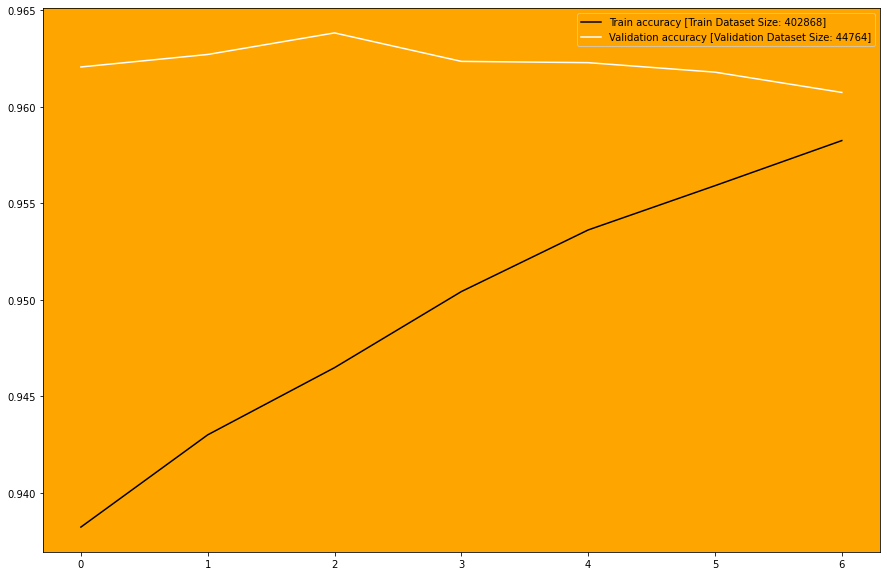

In [32]:
# Plotting the change of accuracy per epoch for both training and validation sets.

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.facecolor']='orange'
plt.figure(figsize=(15,10))
plt.plot(np.arange(0,len(history.history["binary_accuracy"]),1), history.history["binary_accuracy"], c="black")
plt.plot(np.arange(0,len(history.history["val_binary_accuracy"]),1), history.history["val_binary_accuracy"], c="white")
plt.legend(["Train accuracy [Train Dataset Size: {}]".format(training_shape), "Validation accuracy [Validation Dataset Size: {}]".format(validation_shape)])
plt.savefig(os.path.join("models", "change_of_accuracy_plot_{}.jpg".format(uid)))
plt.show()

In [33]:
# Saving the model with a unique ID, so an existing model does not get overwritten

model.save(os.path.join("models", "offensive-text-sentiment-model_{}.h5".format(uid)))